In [38]:
!pip install spacy --user
!pip3 install -U spacy
!python3 -m spacy download it_core_news_sm
!pip3 install spacy
!python -m spacy download it_core_news_sm

  Using cached https://github.com/explosion/spacy-models/releases/download/it_core_news_sm-3.2.0/it_core_news_sm-3.2.0-py3-none-any.whl (21.4 MB)
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_sm')
     |████████████████████████████████| 21.4 MB 1.5 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_sm')


In [39]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import gensim
from gensim.models import Word2Vec
import pandas as pd

In [40]:
df= pd.read_csv('Books.csv')
df

,Unnamed: 0,_id,author,contents,publishing house,year
0,0,Jane Eyre_Feltrinelli_pulito.txt,Charlotte Brontë,Quel giorno era impossibile uscire a passeggio...,Feltrinelli Editore,2014
1,1,Jane Eyre_Treves_pulito.txt,Charlotte Brontë,In quel giorno era impossibile passeggiare. La...,Fratelli Treves Editori,1904


In [41]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [42]:
from spacy.lang.it.stop_words import STOP_WORDS

def clean(x):
  stop = STOP_WORDS
  words  = [w for w in word_tokenize(x.lower()) if w.isalpha() and w not in stop]
  return " ".join(words)

df['contents'] = df['contents'].apply(clean)

In [43]:
import spacy
from spacy.lang.it.examples import sentences 
from tqdm.notebook import tqdm
tqdm.pandas()
nlp = spacy.load('it_core_news_sm')
nlp.max_length = 1064150 
pipe = nlp.pipe(df['contents'], n_process=2, batch_size=2000)

In [44]:
docs = [x for x in tqdm(pipe)]

0it [00:00, ?it/s]

In [45]:
data = df

In [46]:
data['spacy_doc'] = docs

In [47]:
data['POS_spacy'] = data['spacy_doc'].progress_apply(lambda x: [(y.text, y.pos_) for y in x])

  0%|          | 0/2 [00:00<?, ?it/s]

In [48]:
data['lemmatized'] = data['spacy_doc'].progress_apply(lambda x: " ".join([y.lemma_ for y in x if len(x)>1]))

  0%|          | 0/2 [00:00<?, ?it/s]

In [49]:
data['tokens'] = data['spacy_doc'].progress_apply(lambda x: [y.text for y in x])

  0%|          | 0/2 [00:00<?, ?it/s]

In [50]:
data['language'] = data['spacy_doc'].progress_apply(lambda x: set([y.lang_ for y in x]))

  0%|          | 0/2 [00:00<?, ?it/s]

In [51]:
length = {}
for line in data['language']:
    if len(line) in length:
        length[len(line)] += 1
    else:
        length[len(line)] = 1
length

{1: 2}

In [52]:
data['language'] = data['language'].progress_apply(lambda x: list(x)[0])

  0%|          | 0/2 [00:00<?, ?it/s]

In [53]:
data['language'].unique()

array(['it'], dtype=object)

In [54]:
def filter_text_pos(x):
    final_pos_text = []
    for elem in x:
        for pos in pos_list:
            if elem[1] == pos:
                final_pos_text.append(elem[0])
    
    return " ".join(final_pos_text)

In [55]:
pos_list = ["NOUN"]
data["NOUN"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['NOUN_count'] = data['NOUN'].apply(lambda x: len(x.split()))

pos_list = ["PROPN"]
data["PROPN"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['PROPN_count'] = data['PROPN'].apply(lambda x: len(x.split()))

pos_list = ["VERB"]
data["VERB"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['VERB_count'] = data['VERB'].apply(lambda x: len(x.split()))

pos_list = ["ADJ"]
data["ADJ"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['ADJ_count'] = data['ADJ'].apply(lambda x: len(x.split()))

pos_list = ["PRON"]
data["PRON"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['PRON_count'] = data['PRON'].apply(lambda x: len(x.split()))

pos_list = ["ADV"]
data["ADV"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['ADV_count'] = data['ADV'].apply(lambda x: len(x.split()))

pos_list = ["SCONJ"]
data["SCONJ"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['SCONJ_count'] = data['SCONJ'].apply(lambda x: len(x.split()))

In [56]:
!pip install dataframe_image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import nltk.sentiment.vader as vd
from nltk.tokenize import word_tokenize
from PIL import Image
from os import path, getcwd
import dataframe_image as dfi

In [57]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


common_words = get_top_n_words(data['contents'], 50)
cmw = {word: freq for word, freq in common_words}

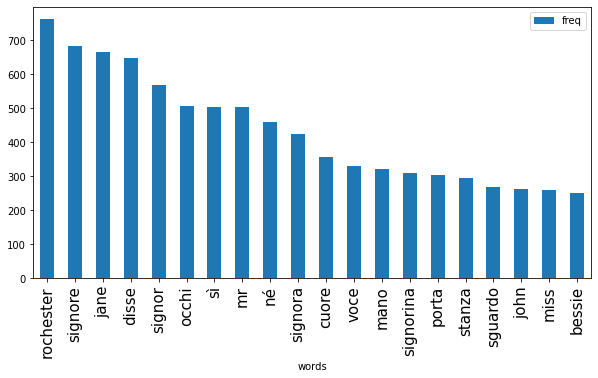

In [58]:
mcw = pd.DataFrame.from_dict(cmw, orient='index').reset_index()
mcw.columns = ["words", "freq"]

mcw = mcw[:20]
mcw.plot(x="words", y="freq", kind="bar", figsize=(10,5), width=0.5)
plt.savefig("images_d\Top20_words.png")
plt.rc('xtick', labelsize=15) 
plt.show()

In [59]:
all_pos = data['POS_spacy'].sum()
all_adjs = [x[0] for x in all_pos if x[1] == "ADJ"]
all_nouns = [x[0] for x in all_pos if x[1] == "NOUN"]
all_propn = [x[0] for x in all_pos if x[1] == "PROPN"]
all_verbs = [x[0] for x in all_pos if x[1] == "VERB"]

In [60]:
Feltrinelli = data.loc[data["_id"] == 'Jane Eyre_Feltrinelli_pulito.txt']
POS_Feltrinelli = Feltrinelli['POS_spacy'].sum()
all_adjs_f = [x[0] for x in POS_Feltrinelli if x[1] == "ADJ"]
all_nouns_f = [x[0] for x in POS_Feltrinelli if x[1] == "NOUN"]
all_propn_f = [x[0] for x in POS_Feltrinelli if x[1] == "PROPN"]
all_verbs_f = [x[0] for x in POS_Feltrinelli if x[1] == "VERB"]

In [61]:
Treves = data.loc[data["_id"] == 'Jane Eyre_Treves_pulito.txt']
POS_Treves = Treves['POS_spacy'].sum()
all_adjs_t = [x[0] for x in POS_Treves if x[1] == "ADJ"]
all_nouns_t = [x[0] for x in POS_Treves if x[1] == "NOUN"]
all_propn_t = [x[0] for x in POS_Treves if x[1] == "PROPN"]
all_verbs_t = [x[0] for x in POS_Treves if x[1] == "VERB"]

TOP POS

In [62]:
pos_counter_f = {}
for x in POS_Feltrinelli:
    if x[1] in pos_counter_f:
        pos_counter_f[x[1]] += 1
    else:
        pos_counter_f[x[1]] = 1
        
top_pos_f = {k: v for k, v in sorted(pos_counter_f.items(), key=lambda item: item[1], reverse=True)}

In [63]:
freq_pos_f = pd.DataFrame.from_dict(top_pos_f, orient="index", columns=["Freq"]).reset_index()
freq_pos_f["R_Freq"] = freq_pos_f.apply(lambda x: np.round(x.Freq / freq_pos_f.Freq.sum(), 2), axis=1)

In [64]:
pos_counter_t = {}
for x in POS_Treves:
    if x[1] in pos_counter_t:
        pos_counter_t[x[1]] += 1
    else:
        pos_counter_t[x[1]] = 1
        
top_pos_t = {k: v for k, v in sorted(pos_counter_t.items(), key=lambda item: item[1], reverse=True)}

In [65]:
freq_pos_t = pd.DataFrame.from_dict(top_pos_t, orient="index", columns=["Freq"]).reset_index()
freq_pos_t["R_Freq"] = freq_pos_t.apply(lambda x: np.round(x.Freq / freq_pos_t.Freq.sum(), 2), axis=1)

In [66]:
compared_pos = {"Feltrinelli": list(top_pos_f.keys())[:len(top_pos_t)], "Freq_Feltrinelli": list(top_pos_f.values())[:len(top_pos_t)], "Treves": top_pos_t.keys(), "Freq_Treves": top_pos_t.values()}
compared_pos = pd.DataFrame(compared_pos)
compared_pos["R_Freq_Feltrinelli"] = compared_pos.apply(lambda x: np.round(x.Freq_Feltrinelli / compared_pos.Freq_Feltrinelli.sum(), 3), axis=1)
compared_pos["R_Freq_Treves"] = compared_pos.apply(lambda x: np.round(x.Freq_Treves / compared_pos.Freq_Treves.sum(), 3), axis=1)
compared_pos = compared_pos.reindex(columns=['Feltrinelli', 'R_Freq_Feltrinelli', 'Treves', 'R_Freq_Treves'])
compared_pos

,Feltrinelli,R_Freq_Feltrinelli,Treves,R_Freq_Treves
0,NOUN,0.280,NOUN,0.281
1,VERB,0.249,VERB,0.260
2,ADJ,0.219,ADJ,0.212
3,CCONJ,0.094,CCONJ,0.086
4,AUX,0.043,AUX,0.049
5,ADV,0.036,PROPN,0.036
6,PROPN,0.032,ADV,0.035
7,DET,0.026,DET,0.022
8,ADP,0.007,PRON,0.006
9,PRON,0.005,ADP,0.004


TOP ADJECTIVES

In [67]:
adj_counter_f = {}
for word in all_adjs_f:
    if word in adj_counter_f:
        adj_counter_f[word] += 1
    else:
        adj_counter_f[word] = 1

top_20_adj_f = {k: v for k, v in sorted(adj_counter_f.items(), key=lambda item: item[1], reverse=True)[:20]}

In [68]:
adj_counter_t = {}
for word in all_adjs_t:
    if word in adj_counter_t:
        adj_counter_t[word] += 1
    else:
        adj_counter_t[word] = 1
            
top_20_adj_t = {k: v for k, v in sorted(adj_counter_t.items(), key=lambda item: item[1], reverse=True)[:20]}

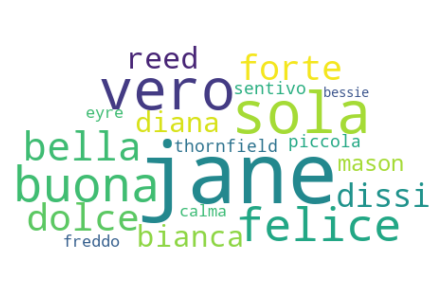

In [69]:
path_cloud = "aa.png"
cloud = np.array(Image.open(path_cloud))
wc_Treves = WordCloud(background_color="white", mask=cloud).generate_from_frequencies(top_20_adj_t)
plt.figure(figsize=(8,5))
plt.imshow(wc_Treves, interpolation="bilinear")
plt.axis("off")
wc_Treves.to_file("images_d\wc_Treves.png")
plt.show()

In [70]:
top_adj = {"Feltrinelli": top_20_adj_f.keys(), "Freq_Feltrinelli": top_20_adj_f.values(), "Treves": top_20_adj_t.keys(), "Freq_Treves": top_20_adj_t.values()}
top_adj = pd.DataFrame(top_adj)
top_adj["R_Freq_Feltrinelli"] = top_adj.apply(lambda x: np.round(x.Freq_Feltrinelli / top_adj.Freq_Treves.sum(), 3), axis=1)
top_adj["R_Freq_Treves"] = top_adj.apply(lambda x: np.round(x.Freq_Feltrinelli / top_adj.Freq_Treves.sum(), 3), axis=1)
top_adj = top_adj.reindex(columns=['Feltrinelli', 'R_Freq_Feltrinelli', 'Treves', 'R_Freq_Treves'])
top_adj

,Feltrinelli,R_Freq_Feltrinelli,Treves,R_Freq_Treves
0,jane,0.162,jane,0.162
1,miss,0.095,sola,0.095
2,vero,0.074,vero,0.074
3,sola,0.063,buona,0.063
4,dissi,0.052,felice,0.052
5,sicuro,0.052,bella,0.052
6,felice,0.048,dolce,0.048
7,diana,0.048,forte,0.048
8,bambina,0.046,dissi,0.046
9,adèle,0.046,reed,0.046


In [71]:
common_adj = list(set(top_adj["Feltrinelli"].values).intersection(set(top_adj["Treves"].values)))
freq_common_f_adj = [adj_counter_f[x] for x in common_adj]
freq_common_t_adj = [adj_counter_t[x] for x in common_adj]
common_adj_df = pd.DataFrame({"Adj" : common_adj, "Freq_Feltrinelli": freq_common_f_adj, "Freq_Treves": freq_common_t_adj } )
common_adj_df = common_adj_df.sort_values(by = ['Freq_Feltrinelli'], ascending = False, ignore_index=True)

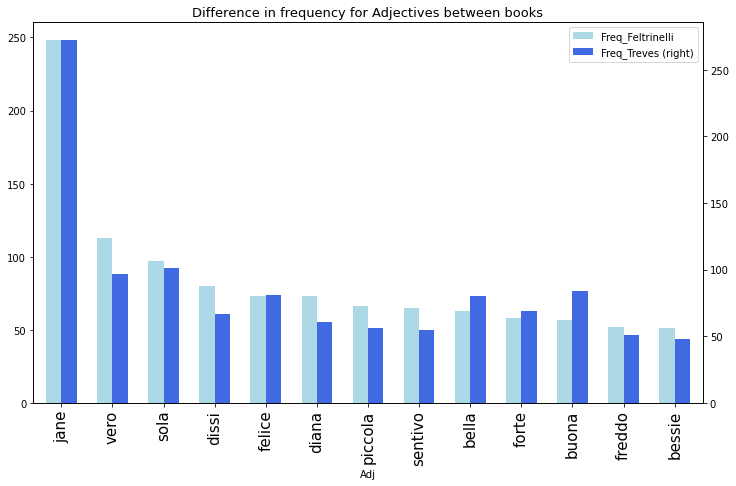

In [72]:
common_adj_df.set_index("Adj").plot(secondary_y=['Freq_Treves'], kind='bar', color=['lightblue', 'royalblue'], figsize=(12,7), width=0.6)
plt.title('Difference in frequency for Adjectives between books', fontsize = 13)
plt.rc('xtick', labelsize=10)
plt.savefig("images_d\Adj_tot_books.png")
plt.show()

Difference in number of Adjectives between books is  3423.0


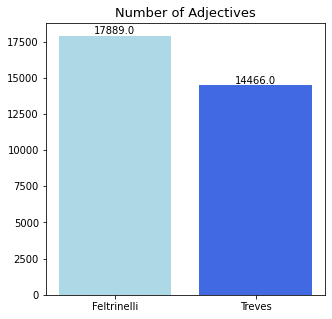

In [73]:
fig, ax = plt.subplots(figsize=(5,5))
labels = (Feltrinelli.ADJ_count.mean(), Treves.ADJ_count.mean())
ax.bar("Feltrinelli", Feltrinelli.ADJ_count.mean(), color=['lightblue'], label='Feltrinelli')
ax.bar("Treves", Treves.ADJ_count.mean(), color=[ 'royalblue'], label='Treves')
rects = ax.patches
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height , label,
            ha='center', va='bottom')
plt.rc('xtick', labelsize=10)
plt.title('Number of Adjectives', fontsize = 13)
print('Difference in number of Adjectives between books is ', Feltrinelli.ADJ_count.mean() - Treves.ADJ_count.mean() )

TOP VERBS

In [74]:
verb_counter_f = {}
for word in all_verbs_f:
    if word in verb_counter_f:
        verb_counter_f[word] += 1
    else:
        verb_counter_f[word] = 1

top_20_verb_f = {k: v for k, v in sorted(verb_counter_f.items(), key=lambda item: item[1], reverse=True)[:20]}

In [75]:
verb_counter_t = {}
for word in all_verbs_t:
    if word in verb_counter_t:
        verb_counter_t[word] += 1
    else:
        verb_counter_t[word] = 1
            
top_20_verb_t = {k: v for k, v in sorted(verb_counter_t.items(), key=lambda item: item[1], reverse=True)[:20]}

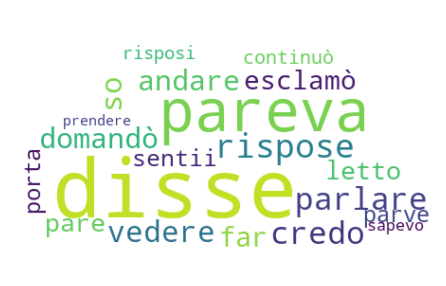

In [76]:
WC_Treves = WordCloud(background_color="white", mask=cloud).generate_from_frequencies(top_20_verb_t)
plt.figure(figsize=(8,5))
plt.imshow(WC_Treves, interpolation="bilinear")
plt.axis("off")
WC_Treves.to_file("images_d\WC_Treves.png")
plt.show()

In [77]:
top_verb = {"Feltrinelli": top_20_verb_f.keys(), "Freq_Feltrinelli": top_20_verb_f.values(), "Treves": top_20_verb_t.keys(), "Freq_Treves": top_20_verb_t.values()}
top_verb = pd.DataFrame(top_verb)
top_verb["R_Freq_Feltrinelli"] = top_verb.apply(lambda x: np.round(x.Freq_Feltrinelli / top_verb.Freq_Feltrinelli.sum(), 3), axis=1)
top_verb["R_Freq_Treves"] = top_verb.apply(lambda x: np.round(x.Freq_Treves / top_verb.Freq_Treves.sum(), 3), axis=1)
top_verb = top_verb.reindex(columns=['Feltrinelli', 'R_Freq_Feltrinelli', 'Treves', 'R_Freq_Treves'])
top_verb

,Feltrinelli,R_Freq_Feltrinelli,Treves,R_Freq_Treves
0,disse,0.161,disse,0.155
1,sembrava,0.072,pareva,0.068
2,parlare,0.067,rispose,0.066
3,vedere,0.065,parlare,0.058
4,andare,0.061,credo,0.057
5,so,0.056,vedere,0.050
6,porta,0.051,so,0.050
7,credo,0.045,andare,0.047
8,sentii,0.041,domandò,0.046
9,sentito,0.041,far,0.044


In [78]:
common_verb = list(set(top_verb["Treves"].values).intersection(set(top_verb["Feltrinelli"].values)))
freq_common_f_verb = [verb_counter_f[x] for x in common_verb]
freq_common_t_verb = [verb_counter_t[x] for x in common_verb]
common_verb_df = pd.DataFrame({"Verb" : common_verb, "Freq_Feltrinelli": freq_common_f_verb, "Freq_Treves": freq_common_t_verb } )
common_verb_df = common_verb_df.sort_values(by = ['Freq_Treves'], ascending = False, ignore_index=True)

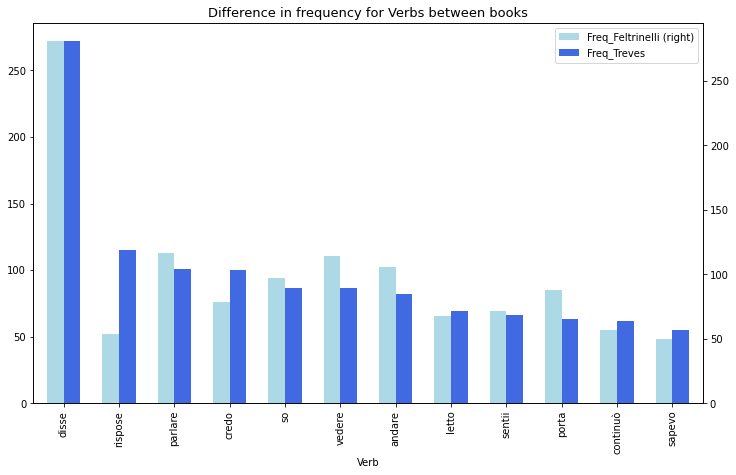

In [79]:
common_verb_df.set_index("Verb").plot(secondary_y=['Freq_Feltrinelli'], kind='bar', color=['lightblue', 'royalblue'], figsize=(12,7), width=0.6)
plt.title('Difference in frequency for Verbs between books', fontsize = 13)
plt.rc('xtick', labelsize=10)
plt.savefig("images_d\Verb_tot.png")
plt.show()

Difference in number of Verbs between books is  -2594.0


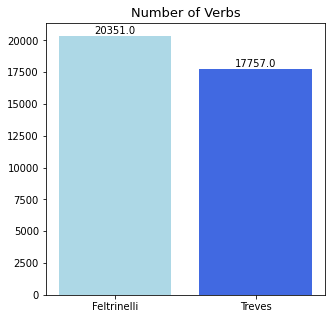

In [80]:
fig, ax = plt.subplots(figsize=(5,5))
labels = (Feltrinelli.VERB_count.mean(), Treves.VERB_count.mean())
ax.bar("Feltrinelli", Feltrinelli.VERB_count.mean(), color=['lightblue'], label='Feltrinelli')
ax.bar("Treves", Treves.VERB_count.mean(), color=[ 'royalblue'], label='Treves')
rects = ax.patches
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height , label,
            ha='center', va='bottom')
plt.title('Number of Verbs', fontsize = 13)
print('Difference in number of Verbs between books is ', Treves.VERB_count.mean() - Feltrinelli.VERB_count.mean() )

TOP NOUNS

In [81]:
noun_counter_f = {}
for word in all_nouns_f:
    if word in noun_counter_f:
        noun_counter_f[word] += 1
    else:
        noun_counter_f[word] = 1
            
top_20_noun_f = {k: v for k, v in sorted(noun_counter_f.items(), key=lambda item: item[1], reverse=True)[:20]}

In [82]:
noun_counter_t = {}
for word in all_nouns_t:
    if word in noun_counter_t:
        noun_counter_t[word] += 1
    else:
        noun_counter_t[word] = 1
            
top_20_noun_t = {k: v for k, v in sorted(noun_counter_t.items(), key=lambda item: item[1], reverse=True)[:20]}

In [83]:
top_noun = {"Feltrinelli": top_20_noun_f.keys(), "Freq_Feltrinelli": top_20_noun_f.values(), "Treves": top_20_noun_t.keys(), "Freq_Treves": top_20_noun_t.values()}
top_noun = pd.DataFrame(top_noun)
top_noun["R_Freq_Feltrinelli"] = top_noun.apply(lambda x: np.round(x.Freq_Feltrinelli / top_noun.Freq_Feltrinelli.sum(), 3), axis=1)
top_noun["R_Freq_Treves"] = top_noun.apply(lambda x: np.round(x.Freq_Treves / top_noun.Freq_Treves.sum(), 3), axis=1)
top_noun = top_noun.reindex(columns=['Feltrinelli', 'R_Freq_Feltrinelli', 'Treves', 'R_Freq_Treves'])
top_noun

,Feltrinelli,R_Freq_Feltrinelli,Treves,R_Freq_Treves
0,signore,0.126,signor,0.125
1,occhi,0.094,signore,0.108
2,stanza,0.066,signora,0.106
3,cuore,0.064,occhi,0.071
4,voce,0.060,signorina,0.063
5,mano,0.059,cuore,0.055
6,parole,0.047,voce,0.053
7,fuoco,0.044,mano,0.048
8,notte,0.044,donna,0.039
9,fairfax,0.044,notte,0.037


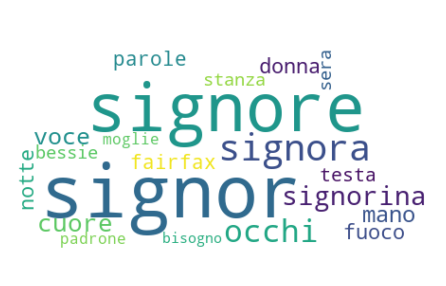

In [84]:
WC_Treves = WordCloud(background_color="white", mask=cloud).generate_from_frequencies(top_20_noun_t)
plt.figure(figsize=(8,5))
plt.imshow(WC_Treves, interpolation="bilinear")
plt.axis("off")
WC_Treves.to_file("images_d\WC_Treves.png")
plt.show()

In [85]:
common_nouns = list(set(top_noun["Treves"].values).intersection(set(top_noun["Feltrinelli"].values)))
freq_common_noun_f = [noun_counter_f[x] for x in common_nouns]
freq_common_noun_t = [noun_counter_t[x] for x in common_nouns]

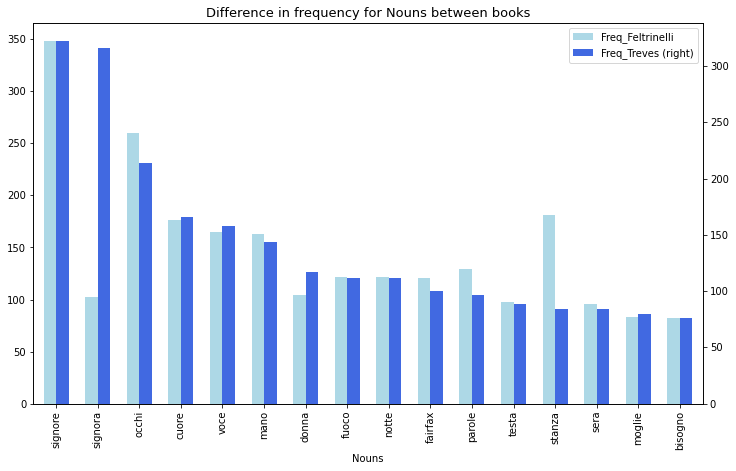

In [86]:
common_noun_df = pd.DataFrame({"Nouns" : common_nouns, "Freq_Feltrinelli": freq_common_noun_f, "Freq_Treves": freq_common_noun_t })
common_noun_df = common_noun_df.sort_values(by = ['Freq_Treves'], ascending = False, ignore_index=True)
common_noun_df.set_index("Nouns").plot(secondary_y=['Freq_Treves'], kind='bar', color=['lightblue', 'royalblue'], figsize=(12,7), width=0.6)
plt.title('Difference in frequency for Nouns between books', fontsize = 13)
plt.rc('xtick', labelsize=10)

Difference in number of nouns between books is  -3794.0


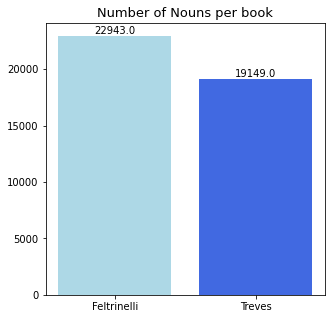

In [87]:
fig, ax = plt.subplots(figsize=(5,5))
labels = (Feltrinelli.NOUN_count.mean(), Treves.NOUN_count.mean())
ax.bar("Feltrinelli", Feltrinelli.NOUN_count.mean(), color=['lightblue'], label='Feltrinelli')
ax.bar("Treves", Treves.NOUN_count.mean(), color=[ 'royalblue'], label='Treves')
rects = ax.patches
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height , label,
            ha='center', va='bottom')
plt.title('Number of Nouns per book', fontsize = 13)
print('Difference in number of nouns between books is ', Treves.NOUN_count.mean() - Feltrinelli.NOUN_count.mean() )

TOP PROPER NOUNS

In [88]:
propn_counter_f = {}
for word in all_propn_f:
    if word in propn_counter_f:
        propn_counter_f[word] += 1
    else:
        propn_counter_f[word] = 1

top_20_propn_f = {k: v for k, v in sorted(propn_counter_f.items(), key=lambda item: item[1], reverse=True)[:20]}

In [89]:
propn_counter_t = {}
for word in all_propn_t:
    if word in propn_counter_t:
        propn_counter_t[word] += 1
    else:
        propn_counter_t[word] = 1
            
top_20_propn_t = {k: v for k, v in sorted(propn_counter_t.items(), key=lambda item: item[1], reverse=True)[:20]}

In [90]:
top_propn = {"Feltrinelli": top_20_propn_f.keys(), "Freq_Feltrinelli": top_20_propn_f.values(), "Treves": top_20_propn_t.keys(), "Freq_Treves": top_20_propn_t.values()}
top_propn = pd.DataFrame(top_propn)
top_propn["R_Freq_Feltrinelli"] = top_propn.apply(lambda x: np.round(x.Freq_Feltrinelli / top_propn.Freq_Feltrinelli.sum(), 3), axis=1)
top_propn["R_Freq_Treves"] = top_propn.apply(lambda x: np.round(x.Freq_Treves / top_propn.Freq_Treves.sum(), 3), axis=1)
top_propn = top_propn.reindex(columns=['Feltrinelli', 'R_Freq_Feltrinelli', 'Treves', 'R_Freq_Treves'])
top_propn

,Feltrinelli,R_Freq_Feltrinelli,Treves,R_Freq_Treves
0,rochester,0.292,rochester,0.327
1,john,0.168,signor,0.136
2,mary,0.078,adele,0.064
3,reed,0.068,camera,0.058
4,dio,0.052,john,0.052
5,jane,0.042,maria,0.052
6,mrs,0.034,jane,0.036
7,helen,0.034,reed,0.033
8,hall,0.027,dio,0.030
9,camera,0.024,iddio,0.029


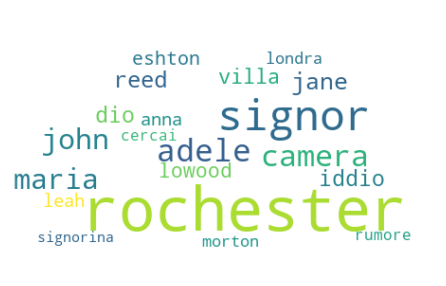

In [91]:
WC_Treves = WordCloud(background_color="white", mask=cloud).generate_from_frequencies(top_20_propn_t)
plt.figure(figsize=(8,5))
plt.imshow(WC_Treves, interpolation="bilinear")
plt.axis("off")
WC_Treves.to_file("images_d\WC_Treves.png")
plt.show()

In [92]:
top_propn = {"Feltrinelli": top_20_propn_f.keys(), "Freq_Feltrinelli": top_20_propn_f.values(), "Treves": top_20_propn_t.keys(), "Freq_Treves": top_20_propn_t.values()}
top_propn = pd.DataFrame(top_propn)
top_propn["R_Freq_Feltrinelli"] = top_propn.apply(lambda x: np.round(x.Freq_Feltrinelli / top_propn.Freq_Feltrinelli.sum(), 3), axis=1)
top_propn["R_Freq_Treves"] = top_propn.apply(lambda x: np.round(x.Freq_Treves / top_propn.Freq_Treves.sum(), 3), axis=1)
top_propn = top_propn.reindex(columns=['Feltrinelli', 'R_Freq_Feltrinelli', 'Treves', 'R_Freq_Treves'])
top_propn

,Feltrinelli,R_Freq_Feltrinelli,Treves,R_Freq_Treves
0,rochester,0.292,rochester,0.327
1,john,0.168,signor,0.136
2,mary,0.078,adele,0.064
3,reed,0.068,camera,0.058
4,dio,0.052,john,0.052
5,jane,0.042,maria,0.052
6,mrs,0.034,jane,0.036
7,helen,0.034,reed,0.033
8,hall,0.027,dio,0.030
9,camera,0.024,iddio,0.029


In [93]:
common_propn = list(set(top_propn["Treves"].values).intersection(set(top_propn["Feltrinelli"].values)))
freq_common_propn_f = [propn_counter_f[x] for x in common_propn]
freq_common_propn_t = [propn_counter_t[x] for x in common_propn]
common_propn_df = pd.DataFrame({"Proper Nouns" : common_propn, "Freq_Feltrinelli": freq_common_propn_f, "Freq_Treves": freq_common_propn_t })
common_propn_df = common_propn_df.sort_values(by = ['Freq_Treves'], ascending = False, ignore_index=True)

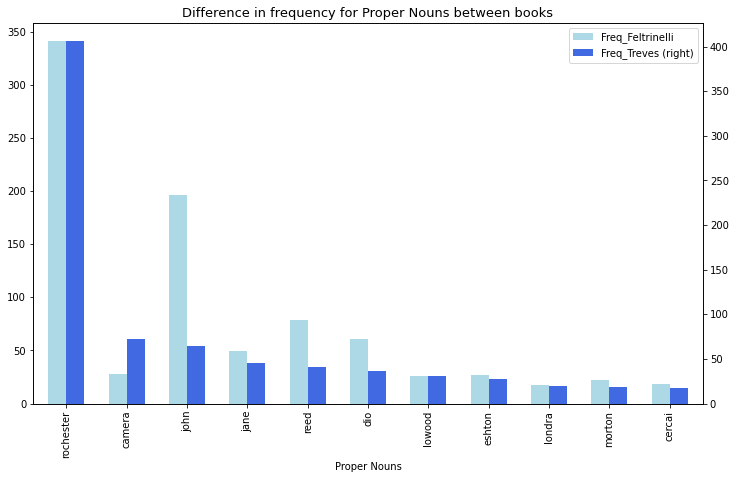

In [94]:
common_propn_df.set_index("Proper Nouns").plot(secondary_y=['Freq_Treves'], kind='bar', color=['lightblue', 'royalblue'], figsize=(12,7), width=0.6)
plt.title('Difference in frequency for Proper Nouns between books', fontsize = 13)
plt.rc('xtick', labelsize=10)
plt.savefig("images_d\Propn_tot_Treves.png")
plt.show()

Difference in number of Proper Nouns between books is  -170.0


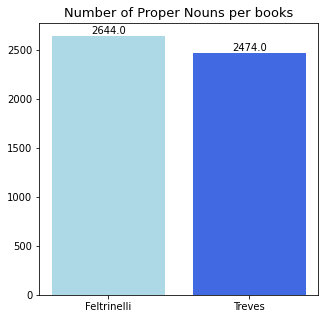

In [95]:
fig, ax = plt.subplots(figsize=(5,5))
labels = (Feltrinelli.PROPN_count.mean(), Treves.PROPN_count.mean())
ax.bar("Feltrinelli", Feltrinelli.PROPN_count.mean(), color=['lightblue'], label='Feltrinelli')
ax.bar("Treves", Treves.PROPN_count.mean(), color=[ 'royalblue'], label='Treves')
rects = ax.patches
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height , label,
            ha='center', va='bottom')
plt.title('Number of Proper Nouns per books', fontsize = 13)
print('Difference in number of Proper Nouns between books is ', Treves.PROPN_count.mean() - Feltrinelli.PROPN_count.mean() )

In [96]:
x1 = pd.Series([Feltrinelli.ADJ_count.mean(),Feltrinelli.NOUN_count.mean(), Feltrinelli.PROPN_count.mean(), Feltrinelli.VERB_count.mean()], index =['Adjectives', 'Nouns', 'Proper Nouns', 'Verbs'])
x2 = pd.Series([Treves.ADJ_count.mean(), Treves.NOUN_count.mean(), Treves.PROPN_count.mean(), Treves.VERB_count.mean()], index =['Adjectives', 'Nouns', 'Proper Nouns', 'Verbs'])            
x3 = pd.Series([Treves.ADJ_count.mean()-Feltrinelli.ADJ_count.mean(), Treves.NOUN_count.mean()-Feltrinelli.NOUN_count.mean(), Treves.PROPN_count.mean()-Feltrinelli.PROPN_count.mean(), Treves.VERB_count.mean()-Feltrinelli.VERB_count.mean()], index =['Adjectives', 'Nouns', 'Proper Nouns', 'Verbs'])            
X = {'Feltrinelli' : x1, 'Treves': x2 , 'Difference' : x3}
diff_pos = pd.DataFrame(X)
diff_pos

,Feltrinelli,Treves,Difference
Adjectives,17889.0,14466.0,-3423.0
Nouns,22943.0,19149.0,-3794.0
Proper Nouns,2644.0,2474.0,-170.0
Verbs,20351.0,17757.0,-2594.0
